In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

import pandas as pd
import bz2
import json
import re
import pickle
import string

# the data file in github is data/
# the local data file is Data/
data_folder = './data/' 

### Simple explorations of the movie medadata

In [2]:
cmu_path = "data/MovieSummaries/"
corenlp_path = "data/CoreNLP/"
summary_raw_path = corenlp_path+"corenlp_plot_summaries/"
summary_path = corenlp_path+"corenlp_plot_summaries_xml/"
movies_path = cmu_path+"movie.metadata.tsv"
characters_path = cmu_path+"character.metadata.tsv"
plot_path = cmu_path+"plot_summaries.txt"

In [4]:
movies_column_names = [
    "wikipedia_id",
    "freebase_id",
    "name",
    "release_date",
    "box_office_revenue",
    "runtime",
    "languages",
    "countries",
    "genres"
]
# Prev: movies = pd.read_csv(data_folder + "movie.metadata.tsv", sep = '\t', 
# names = ["WikiID","FreebaseID","Name", "Release_date", "Revenue","Runtime", "Languages","Countries", "Genres"])

characters_column_names = [
    "wikipedia_id",
    "freebase_id",
    "release_date",
    "character_name",
    "actor_dob",
    "actor_gender",
    "actor_height",
    "actor_ethnicity",
    "actor_name",
    "actor_age",
    "freebase_character_map",
    "freebase_character_id",
    "freebase_actor_id"
]

plot_column_names = ['wikipedia_id', 'summary']

In [5]:
movies = pd.read_csv(movies_path, sep='\t', header=None, names=movies_column_names)
characters = pd.read_csv(characters_path, sep='\t', header=None, names=characters_column_names)
plots = pd.read_csv(plot_path, sep='\t', header=None, names=plot_column_names)

In [6]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   wikipedia_id        81741 non-null  int64  
 1   freebase_id         81741 non-null  object 
 2   name                81741 non-null  object 
 3   release_date        74839 non-null  object 
 4   box_office_revenue  8401 non-null   float64
 5   runtime             61291 non-null  float64
 6   languages           81741 non-null  object 
 7   countries           81741 non-null  object 
 8   genres              81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


In [9]:
# Looking at the time span of the movies.
from datetime import datetime, date, time
mv_yr = movies.release_date.dropna().apply(lambda x: x)
print(movies.release_date.dropna().iloc[57571])
print(movies[movies.release_date == "1010-12-02"])

yrs = []
cnt = 0
for yr in mv_yr:
    k = int(yr[0:4])
    cnt = cnt + 1
    yrs.append(k)

np.sort(yrs)

# Interesting discovery. 
# The movie 'Hunting Season' is acutally out on 2010.


1010-12-02
       wikipedia_id freebase_id            name release_date  \
62836      29666067  /m/0fphzrf  Hunting Season   1010-12-02   

       box_office_revenue  runtime  \
62836          12160978.0    140.0   

                                               languages  \
62836  {"/m/02hwyss": "Turkish Language", "/m/02h40lc...   

                     countries  \
62836  {"/m/01znc_": "Turkey"}   

                                                  genres  
62836  {"/m/0lsxr": "Crime Fiction", "/m/02n4kr": "My...  


array([1010, 1888, 1889, ..., 2016, 2016, 2016])

In [10]:
# As we have seen from the previous block, the release time for 'Hunting Season' is wrong. We hereby crorrect this mistake.
movies['release_date'] = movies['release_date'].replace(['1010-12-02'], '2010-12-02')

In [11]:
movies[movies.runtime == 2880]

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
68223,884492,/m/03lm_0,The Longest Most Meaningless Movie in the World,1968,NaN,2880.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/0424mc"": ""Experimental film""}"


In [30]:
#Looking at the runtime of movies
import seaborn as sns
mv_yr_runtime = movies[["release_date","runtime"]].dropna()
mv_yr_runtime['re_yr'] = mv_yr_runtime.release_date.apply(lambda x: int(x[0:4]))
mv_yr_runtime[mv_yr_runtime.runtime<3000].runtime.describe()

count    58626.000000
mean        93.695856
std         43.118155
min          0.000000
25%         81.000000
50%         93.000000
75%        107.000000
max       2880.000000
Name: runtime, dtype: float64

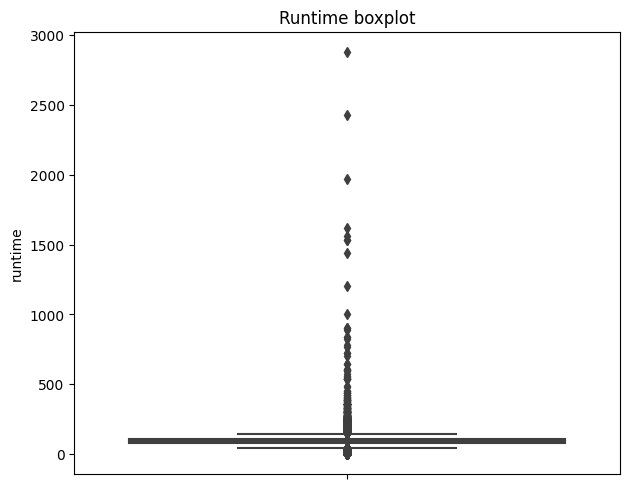

In [25]:
# Using the boxplot to see the runtime distribution
fig = plt.plot(figsize = (20, 10))
sns.boxplot(y = "runtime", data = mv_yr_runtime[mv_yr_runtime.runtime < 3000])
plt.tight_layout()
plt.title("Runtime boxplot")
plt.show()

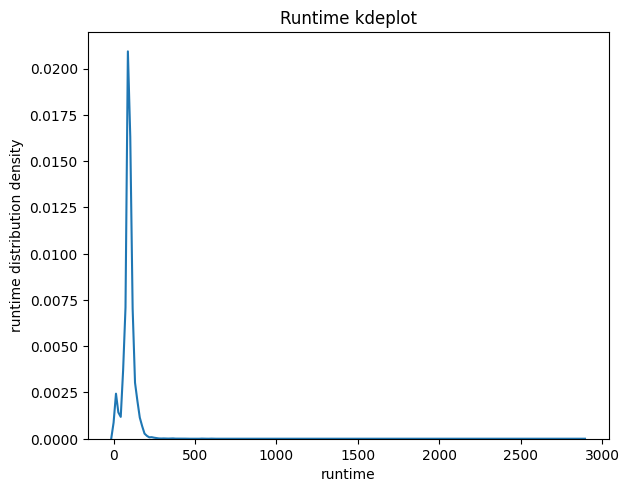

In [34]:
# drawing the kde graph of runtime
fig = plt.plot(figsize = (20, 10))
sns.kdeplot(mv_yr_runtime[mv_yr_runtime.runtime<3000].runtime)
plt.tight_layout()
plt.title("Runtime kdeplot")
plt.ylabel("runtime distribution density")
plt.show()

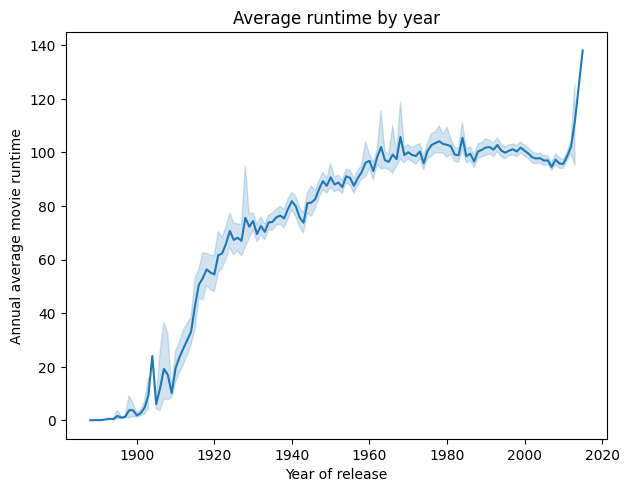

In [33]:
# Average runtime (by year) 
sns.lineplot(data = mv_yr_runtime[(mv_yr_runtime.runtime<3000) & (mv_yr_runtime.re_yr>1200)], x = "re_yr", y = "runtime", legend = "full")
plt.tight_layout()
plt.title("Average runtime by year")
plt.xlabel("Year of release")
plt.ylabel("Annual average movie runtime")
plt.show()

### Explorations of the character data

In [35]:
characters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   wikipedia_id            450669 non-null  int64  
 1   freebase_id             450669 non-null  object 
 2   release_date            440674 non-null  object 
 3   character_name          192794 non-null  object 
 4   actor_dob               344524 non-null  object 
 5   actor_gender            405060 non-null  object 
 6   actor_height            154824 non-null  float64
 7   actor_ethnicity         106058 non-null  object 
 8   actor_name              449441 non-null  object 
 9   actor_age               292556 non-null  float64
 10  freebase_character_map  450669 non-null  object 
 11  freebase_character_id   192804 non-null  object 
 12  freebase_actor_id       449854 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 44.7+ MB


In [36]:
# It is possible that, the same character will appear in different movies.
characters[characters.character_name == "Robin Hood"]

,wikipedia_id,freebase_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id
54984,556241,/m/02pp19,1993-07-28,Robin Hood,1962-10-26,M,1.83,/m/0152s7,Cary Elwes,30.0,/m/0k2m26,/m/06j7x,/m/0219q
115117,723582,/m/035t7n,1952-06-26,Robin Hood,1919-06-11,M,NaN,NaN,Richard Todd,33.0,/m/02tbhw6,/m/06j7x,/m/0147bj
160468,2071706,/m/06k5xq,1976-03-11,Robin Hood,1930-08-25,M,1.89,/m/03lmx1,Sean Connery,45.0,/m/0k2lw_,/m/06j7x,/m/06mr6
195730,62084,/m/0gssy,1938,Robin Hood,1909-06-20,M,1.88,/m/033tf_,Errol Flynn,28.0,/m/0k48xm,/m/0gz66n0,/m/0hnp7
347655,982180,/m/03wh1s,1973-11-08,Robin Hood,1935-02-16,M,NaN,NaN,Brian Bedford,38.0,/m/0k2m0f,/m/05yxn25,/m/0bmr4f
361719,3370990,/m/0983nh,1949,Robin Hood,1909-06-20,M,1.88,/m/033tf_,Errol Flynn,39.0,/m/09l3pqd,/m/0gz66hf,/m/0hnp7
374250,261402,/m/01msrb,1991-06-14,Robin Hood,1955-01-18,M,1.85,/m/09vc4s,Kevin Costner,36.0,/m/0k2m4s,/m/06j7x,/m/0127m7
422419,157172,/m/014nbs,1981-07-13,Robin Hood,1939-10-27,M,1.96,/m/02w7gg,John Cleese,41.0,/m/0k74q8,/m/06j7x,/m/041c4


In [37]:
len(characters.wikipedia_id.unique())

64330

### Will merging the movies df and the characters df be helpful?

In [39]:
movie_char = pd.merge(movies, characters, left_on = "wikipedia_id", right_on = "wikipedia_id")
print(len(movie_char.wikipedia_id.unique()))

64330


In [40]:
# We are dealing with the sex stats, thus the NA values of actor genders are not helpful. 
# Here we remove columns with NA actor_gender values.
movie_char = movie_char.dropna(subset = ['actor_gender'])

In [43]:
# transforming the sex data into a more flexible format.
movie_char['MaleActor'] = (movie_char.actor_gender == 'M').astype(int)
movie_char['FemaleActor'] = (movie_char.actor_gender == 'F').astype(int)

In [44]:
# Grouping by the data by films. In each grouped dataframe, summing the sex stats of male and female, we get the gender sum of each flim.

#Also, use: df.groupby('A').B.agg(['min', 'max'])
movie_char_GpBy = movie_char.groupby(by = 'wikipedia_id')

In [45]:
SexStats = movie_char_GpBy.apply(lambda x: x[['MaleActor', 'FemaleActor']].sum())

In [46]:
SexStats = SexStats.rename(columns={'MaleActor': 'MaleCount', 'FemaleActor': 'FemaleCount'})

In [47]:
SexStats

,MaleCount,FemaleCount
wikipedia_id,,
330,0,4
3217,10,3
3333,8,6
3746,11,3
3837,18,2
...,...,...
37322106,1,2
37373877,3,3
37476824,6,4


In [48]:
movie_gender = pd.merge(movies, SexStats, left_on = "wikipedia_id", right_index = True)

We have counted the apprearence of male, female actors in each film, and stored them in the column: '__MaleCount__', '__FemaleCount__'

__Please also note that:__ the result is derived after removing the rows with the 'Actor_gender' being NA.

In [49]:
movie_gender

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres,MaleCount,FemaleCount
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",11,6
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",11,4
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",2,2
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1,1
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",2,1
...,...,...,...,...,...,...,...,...,...,...,...
81733,23851782,/m/06_vb43,The Ghost Train,1941-05-03,NaN,82.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",7,4
81735,32468537,/m/0crwd9y,Shadow Boxing 2,2007-10-18,NaN,132.0,"{""/m/06b_j"": ""Russian Language"", ""/m/02h40lc"":...","{""/m/06bnz"": ""Russia""}","{""/m/01z02hx"": ""Sports"", ""/m/0lsxr"": ""Crime Fi...",6,1
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",2,0
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",10,5


In [50]:
# We want to see how the difference of Male, Female actors numbers change over time.

# We are dealing with time, so NA time for us is not useful. We drop rows with NA release_date values
movie_gender = movie_gender.dropna(subset = ['release_date'])

# We only care about the year time, so we cut the year from the Release_data column, and place the year at column 'Release_year'
movie_gender['release_year'] = movie_gender.release_date.apply(lambda x: str(x)[0:4])

# Derive the male--female difference
movie_gender['SexDiff'] = movie_gender.MaleCount - movie_gender.FemaleCount

# Sorting by time
movie_gender =  movie_gender.sort_values(by = 'release_year').copy() 

E:\Anaconda\envs\ADA\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
E:\Anaconda\envs\ADA\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


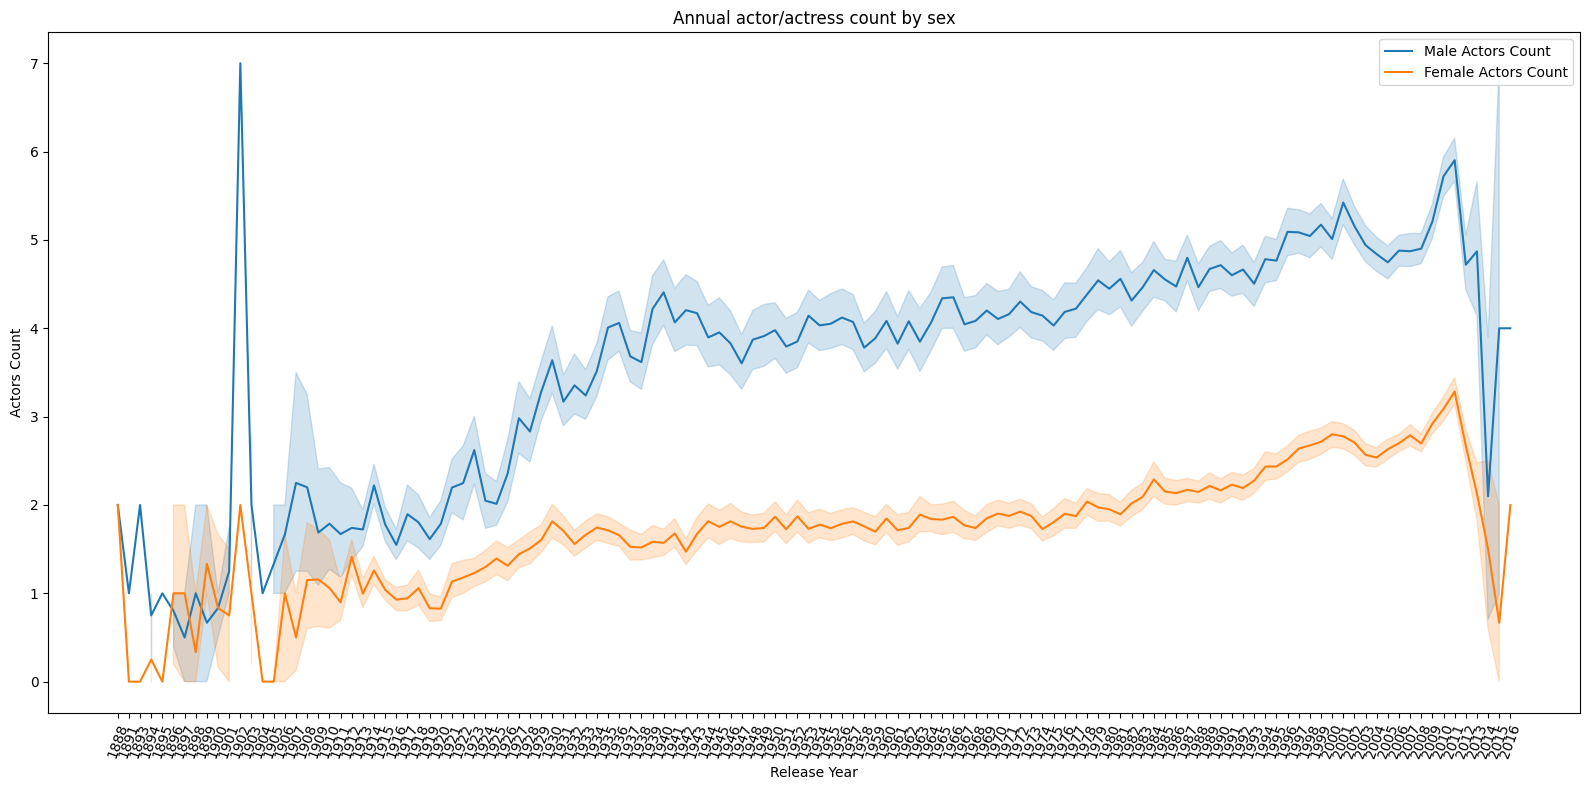

In [52]:
# Plotting the annual actor count by sex. Do we see any patterns in their variance?
plt.figure(figsize=(16,8))
ax = sns.lineplot(data = movie_gender, x = 'release_year', y = 'MaleCount', legend = "full", label = "Male Actors Count")
ax = sns.lineplot(data = movie_gender, x = 'release_year', y = 'FemaleCount', legend = "full", label = "Female Actors Count")
ax.set_xticks(np.unique(movie_gender.release_year.values))
ax.set_xticklabels(np.unique(movie_gender.release_year.values), rotation=70)
plt.xlabel("Release Year")
plt.ylabel("Actors Count")
plt.title("Annual actor/actress count by sex")
plt.tight_layout()
plt.show()

For comparison, we also draw the annual actor count difference, ratio across two genders.

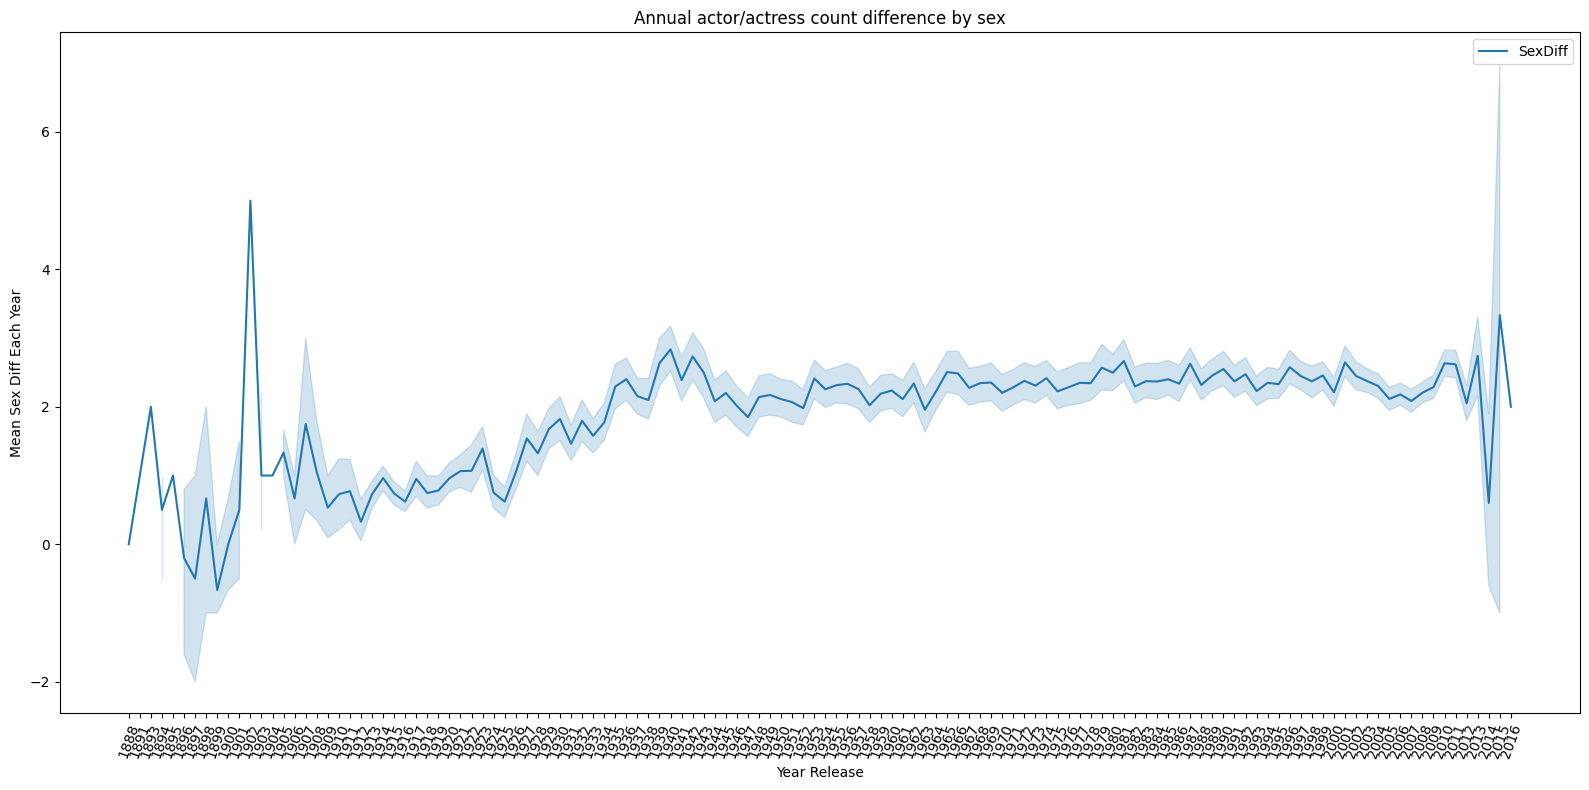

In [54]:
# Plotting the annual actor count difference by sex. Do we see any patterns in their variance?
plt.figure(figsize = (16,8))
ax = sns.lineplot(data = movie_gender, x = 'release_year', y = 'SexDiff', legend = "full", label = "SexDiff")
ax.set_xticks(np.unique(movie_gender.release_year.values))
ax.set_xticklabels(np.unique(movie_gender.release_year.values), rotation=70)
plt.xlabel("Year Release")
plt.ylabel("Mean Sex Diff Each Year")
plt.title("Annual actor/actress count difference by sex")
plt.tight_layout()
plt.show()

We observe two patterns:
- Data from 1868 to 1908 and data in 2014-2015 contains big variance. This may be originated from lack of data, we will see to it later.
- From 1908 to 1940, the difference of male actor count from female actress count is increasing, and stayed stable (around 2) ever since.

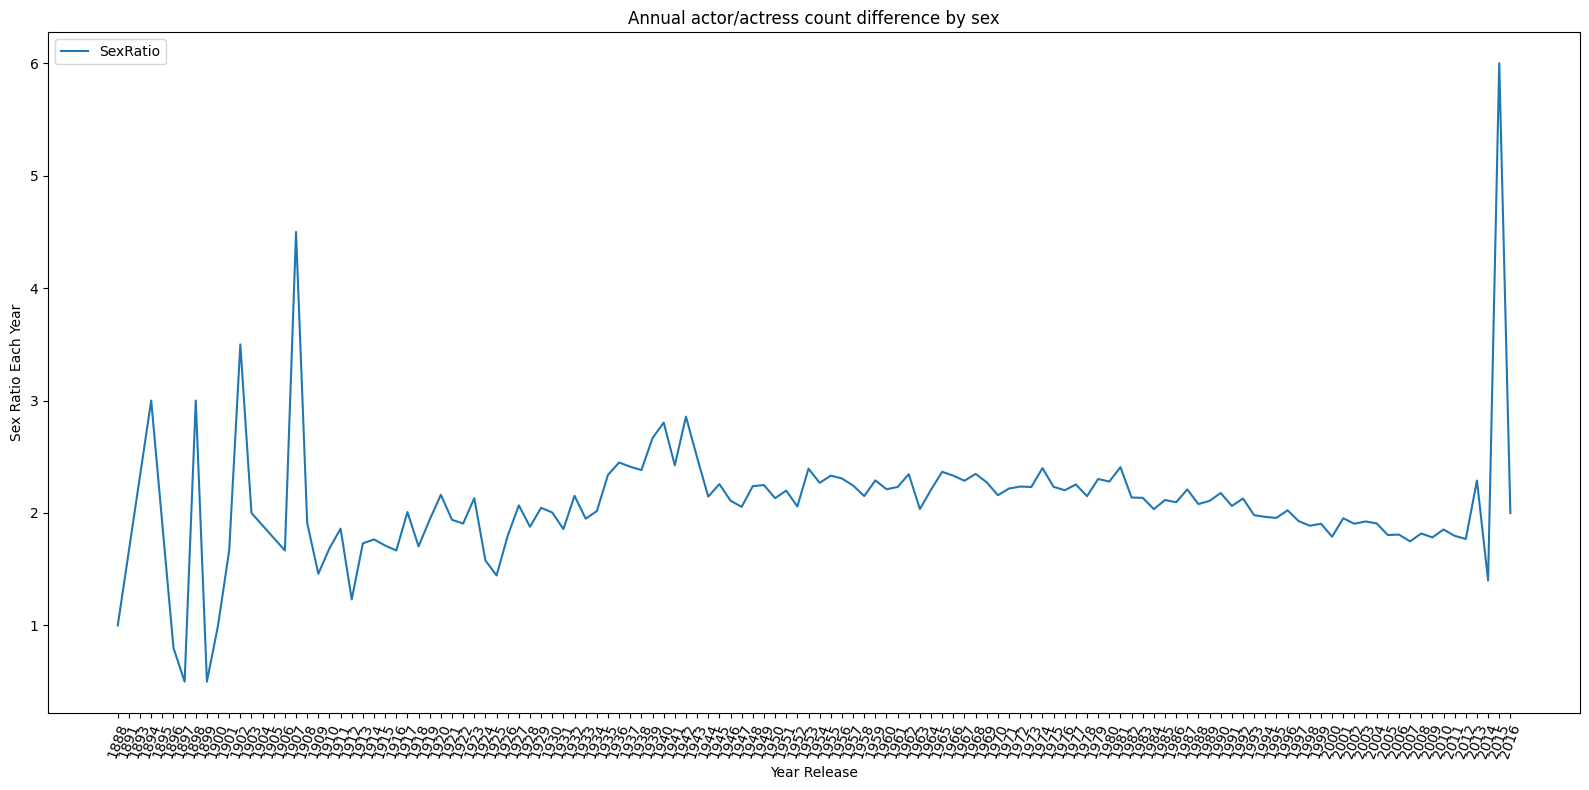

In [144]:
# Plotting the annual actor count ratio by sex. Do we see any patterns in their variance?
movie_gender_GpBy_time = movie_gender.groupby(by = 'release_year')
male_count_year = movie_gender_GpBy_time.apply(lambda x: x.MaleCount.sum())
female_count_year = female_sum = movie_gender_GpBy_time.apply(lambda x: x.FemaleCount.sum())
sex_ratio = male_count_year / female_count_year

# For years when we obtain inf ratio (usually because of little sample), we set the inf value to NA
sex_ratio.replace([np.inf, -np.inf], np.nan, inplace=True)

sex_ratio = pd.DataFrame(sex_ratio, columns = ['M/F_ratio']).reset_index()

# Plotting
plt.figure(figsize = (16,8))
ax = sns.lineplot(data = sex_ratio, x = 'release_year', y = 'M/F_ratio', legend = "full", label = "SexRatio")
ax.set_xticks(np.unique(sex_ratio.release_year.values))
ax.set_xticklabels(np.unique(sex_ratio.release_year.values), rotation=70)
plt.xlabel("Year Release")
plt.ylabel("Sex Ratio Each Year")
plt.title("Annual actor/actress count difference by sex")
plt.tight_layout()
plt.show()

Note that we have huge data variance in the first the last few years, data may not be representative.
The pattern we observe here is somewhat different.
- Ratio start to be close to 1, then goes up, finally goes down.

__We are interested in how may films are released in each year. If there are few films released that year, data at that year may not be repesentative.__

In [93]:
# deriving the annual release data
release_num_yr = movie_gender.groupby(by = 'release_year').wikipedia_id.agg('count')
release_num_yr

release_num_yr.describe()

count     126.000000
mean      475.936508
std       438.101682
min         1.000000
25%       224.500000
50%       394.500000
75%       563.750000
max      1955.000000
Name: wikipedia_id, dtype: float64

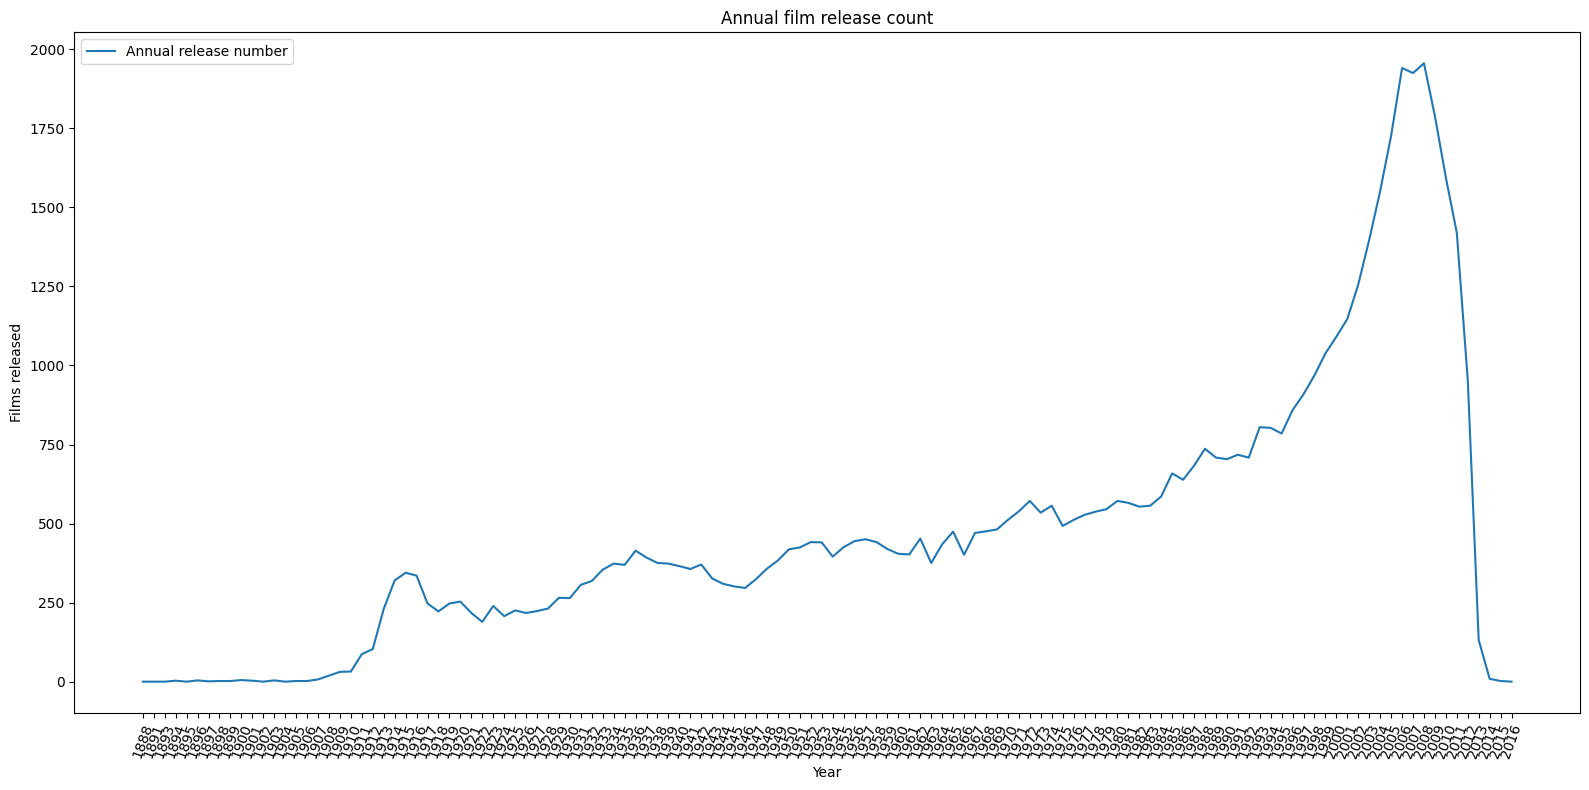

In [94]:
# Plotting the annual release stats.
plt.figure(figsize = (16,8))
ax = sns.lineplot(data = release_num_yr, x = release_num_yr.index, y = release_num_yr.values, legend = "full", label = "Annual release number")
ax.set_xticks(np.unique(sex_ratio.release_year.values))
ax.set_xticklabels(np.unique(sex_ratio.release_year.values), rotation=70)
plt.xlabel("Year")
plt.ylabel("Films released")
plt.title("Annual film release count")
plt.tight_layout()
plt.show()

array([[<AxesSubplot:title={'center':'annual_count'}>]], dtype=object)

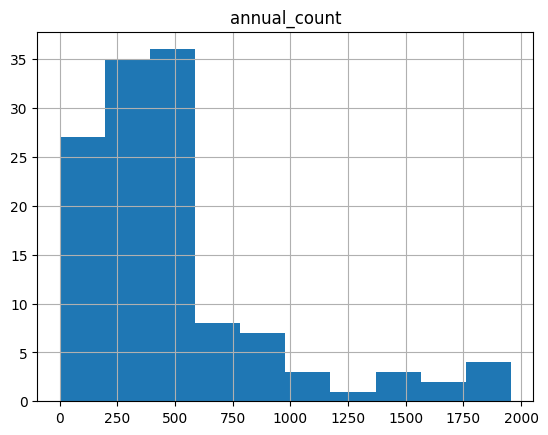

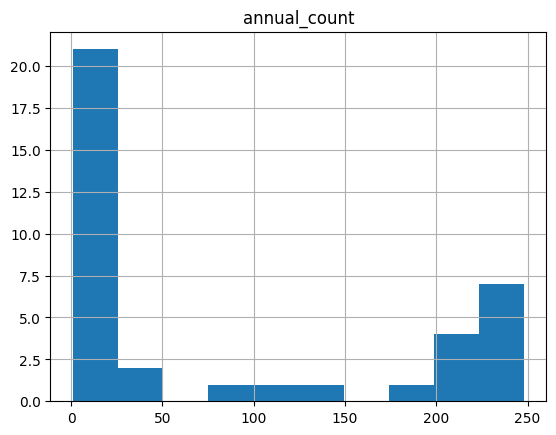

In [123]:
release_num_df = pd.DataFrame(release_num_yr)
release_num_df.columns = ['annual_count']
release_num_df.hist()
release_num_df[release_num_df.annual_count<250].hist()

In [125]:
release_num_df[release_num_df.annual_count<50]

,annual_count
release_year,
1888,1
1891,1
1893,1
1894,4
1895,1
1896,5
1897,2
1898,3
1899,3


__Without consider to augment the data, we start from trimming the tailed data.__

In [135]:
movie_gender_trimmed = movie_gender[(movie_gender.release_year < '2014') & (movie_gender.release_year > '1910')]

... And we plot again!

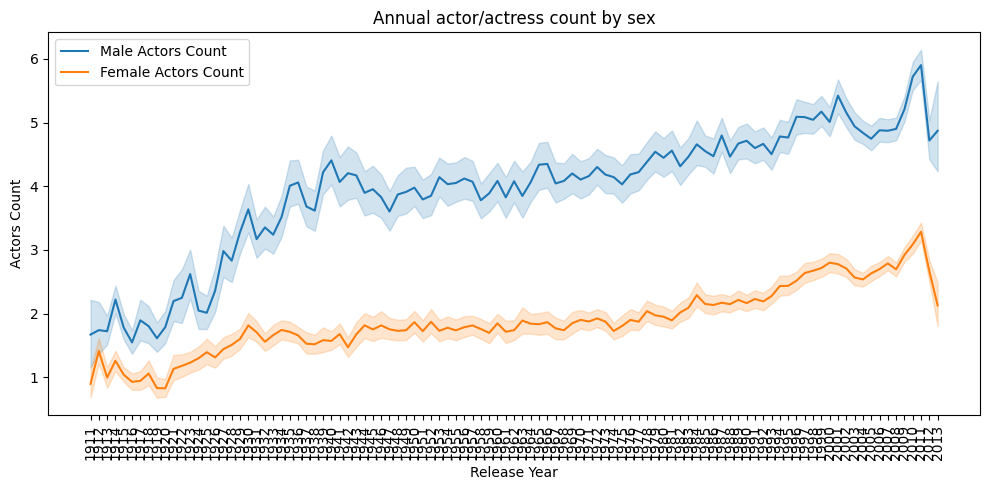

In [138]:
# Plotting the annual actor count by sex. Do we see any patterns in their variance?
plt.figure(figsize=(10,5))
ax = sns.lineplot(data = movie_gender_trimmed, x = 'release_year', y = 'MaleCount', legend = "full", label = "Male Actors Count")
ax = sns.lineplot(data = movie_gender_trimmed, x = 'release_year', y = 'FemaleCount', legend = "full", label = "Female Actors Count")
ax.set_xticks(np.unique(movie_gender_trimmed.release_year.values))
ax.set_xticklabels(np.unique(movie_gender_trimmed.release_year.values), rotation=90)
plt.xlabel("Release Year")
plt.ylabel("Actors Count")
plt.title("Annual actor/actress count by sex")
plt.tight_layout()
plt.show()

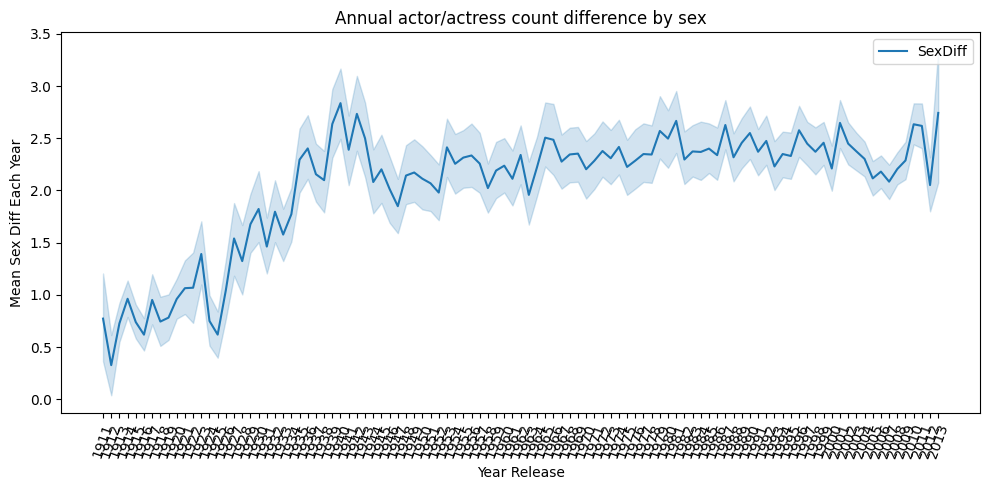

In [140]:
# Plotting the annual actor count difference by sex. Do we see any patterns in their variance?
plt.figure(figsize = (10,5))
ax = sns.lineplot(data = movie_gender_trimmed, x = 'release_year', y = 'SexDiff', legend = "full", label = "SexDiff")
ax.set_xticks(np.unique(movie_gender_trimmed.release_year.values))
ax.set_xticklabels(np.unique(movie_gender_trimmed.release_year.values), rotation=70)
plt.xlabel("Year Release")
plt.ylabel("Mean Sex Diff Each Year")
plt.title("Annual actor/actress count difference by sex")
plt.tight_layout()
plt.show()

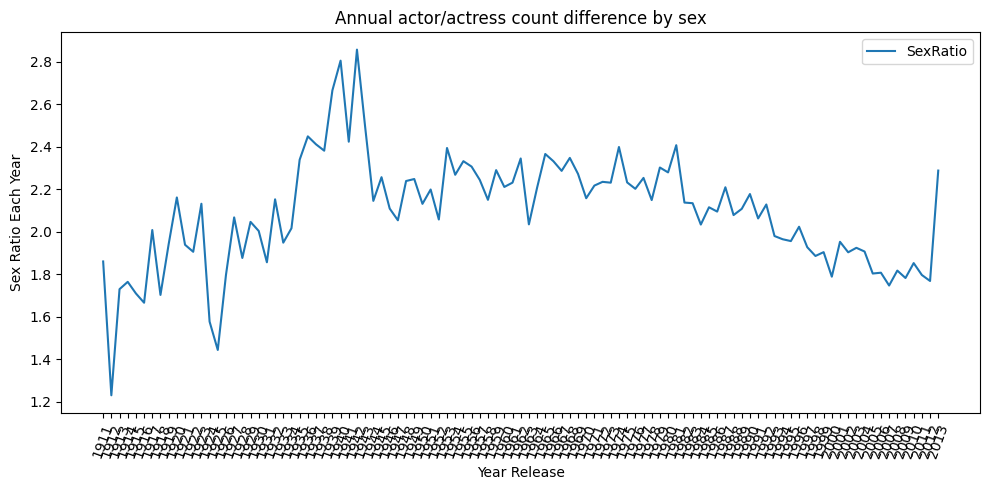

In [145]:
# Plotting the annual actor count ratio by sex. Do we see any patterns in their variance?
movie_gender_GpBy_time = movie_gender_trimmed.groupby(by = 'release_year')
male_count_year = movie_gender_GpBy_time.apply(lambda x: x.MaleCount.sum())
female_count_year = female_sum = movie_gender_GpBy_time.apply(lambda x: x.FemaleCount.sum())
sex_ratio = male_count_year / female_count_year


sex_ratio = pd.DataFrame(sex_ratio, columns = ['M/F_ratio']).reset_index()

# Plotting
plt.figure(figsize = (10,5))
ax = sns.lineplot(data = sex_ratio, x = 'release_year', y = 'M/F_ratio', legend = "full", label = "SexRatio")
ax.set_xticks(np.unique(sex_ratio.release_year.values))
ax.set_xticklabels(np.unique(sex_ratio.release_year.values), rotation=70)
plt.xlabel("Year Release")
plt.ylabel("Sex Ratio Each Year")
plt.title("Annual actor/actress count difference by sex")
plt.tight_layout()
plt.show()

__Some analysis:__
We assume that:

$ \frac{Male}{Female} = f(t) $

Therefore we have:

$Male - Female = Female(f(t) - 1)$

We observe that:
- $Male - Female = Female(f(t) - 1)$ increases to summit at 1941, then decreases and stays stable.
- $\frac{Male}{Female} = f(t)$  increases to summit at 1941, then decreases all the way.

We conclude that the ratio of male-female attendance in films first increases (perhaps because of WWII!) then decreases (peace!) but genreally there are more men than
women in the movie industry.

To count for the stable variation of actors count difference, we explain that it is because the increase of absolute number of women actress.

__More to do:__

- Perhaps augment the data after 2013, see more recent results.
- What happened in 2013? there is an obvious peak.
- Perhaps we can focus on regional data e.g. Asia, North Amerika, Europe, etc.